#### El objetivo de este proyecto es clasificar casas segun donde se encuentren y el ingreso medio, se trabajara con el data set de California Housing
- Se construyó utilizando los datos del censo de California de 1990. Contiene una fila por grupo de bloques censales. Un grupo de bloques es la unidad geográfica más pequeña para la que se publican datos del censo de USA.

# EDA

### Carga de datos
- Cargaré los datos de un url utilizando la funcion pd.read_csv de pandas.

In [109]:
# Importo la libreria pandas para cargar los datos.
import pandas as pd

data = pd.read_csv('https://breathecode.herokuapp.com/asset/internal-link?id=809&path=housing.csv')


# Con este script solo guardo el DataFrame de pandas para tener fisicamente los datos
data.to_csv('../data/raw/data_raw.csv')
print('Datos guardados en data/raw correctamente')

Datos guardados en data/raw correctamente


In [110]:
# Utilizo head para observar las primeras 10 filas del conjunto de datos y ver el nombre de las columnas que lo conforman
data.head(10)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


- Como el objetivo es clasificar casas según su ubicacion y el ingreso medio, solo trabajaré con las columnas que sean relevantes al objetivo.
-
- En este caso solo nos interesan las columnas Latitude, Longitude, MedInc.

- Por lo que el siguiente paso es eliminar el resto, para ello creare una copia de la data unicamente con esas columnas, y sobre esa copia trabajaré.

In [111]:
# Selecciono las columnas que me interesan.
data_copy = data[['Latitude', 'Longitude', 'MedInc']]
# Ahora visualizo las 10 primeras filas del nuevo data frame
data_copy.head(10)

,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252
1,37.86,-122.22,8.3014
2,37.85,-122.24,7.2574
3,37.85,-122.25,5.6431
4,37.85,-122.25,3.8462
5,37.85,-122.25,4.0368
6,37.84,-122.25,3.6591
7,37.84,-122.25,3.1200
8,37.84,-122.26,2.0804
9,37.84,-122.25,3.6912


### Limpieza de datos
- Una vez seleccionadas las columnas es momento de buscar valores nulos oh duplicados para que el modelo pueda trabajar con ellas.
- Utilizaré .isnull().sum() para ver la suma de los nulos.
- Utilizaré .duplicated() para ver aquellos valores duplicados.

In [112]:
# Buscar valores nulos
data_copy.isnull().sum()

Latitude     0
Longitude    0
MedInc       0
dtype: int64

No se detectaron valores nulos, ahora procederé a buscar duplicados.

In [113]:
# Buscar duplicados
data_copy.duplicated().sum()


np.int64(5)

In [114]:
# Elimino los 5 duplicados utilizando .drop_duplicates()
data_copy = data_copy.drop_duplicates()

In [115]:
data_copy.duplicated().sum()

np.int64(0)

### Ingenieria de caracteristicas
- Como utilizaremos el modelo KMean, para clustering, primero es necesario escalar y reducir la dimensionalidad de la data.
- Para ello primero utilizaré StandarScaled para llevar a todas las columnas a una desviacion estandar entre 0 y 1, asi podemos evitar outliers
- Una vez escalados los datos entrenaré el modelo KMeans
- Debido a que unicamente me quede con 3 columnas no reducire la dimensionalidad usando PCA, primero probaré el algoritmo con esas 3 columnas y lo utilizaré posterior para comparar los resultados.

In [116]:
# Importo la libreria que contiene el algoritmo StandarScaler()
from sklearn.preprocessing import StandardScaler

# Creo el escalador scaler
scaler = StandardScaler()

# Entreno la data con el escalador
scaler.fit(data_copy)

# Genero un nuevo data set con la data escalada
data_scaled = scaler.transform(data_copy)

# Visualizo la nueva data, esta se compone en 3 columnas 0, 1, 2
data_scaled


array([[ 1.0524197 , -1.32767173,  2.35121759],
       [ 1.04305633, -1.32268076,  2.33865974],
       [ 1.03837465, -1.33266271,  1.78780259],
       ...,
       [ 1.77808043, -0.82358342, -1.1445092 ],
       [ 1.77808043, -0.87349315, -1.05628763],
       [ 1.74999034, -0.83356536, -0.78117564]], shape=(20635, 3))

Ahora entrenare el algoritmo KMeans para obtener el mejor agrupamiento (k), para ello utilizaré el metodo de codo, que practicamente consiste en iterar sobre un numero de clusters por ejemplo 10 y almacenar el resultado en una lista, sobre esa lista evaluare cual dio mejor resultado y me quedare con esa K

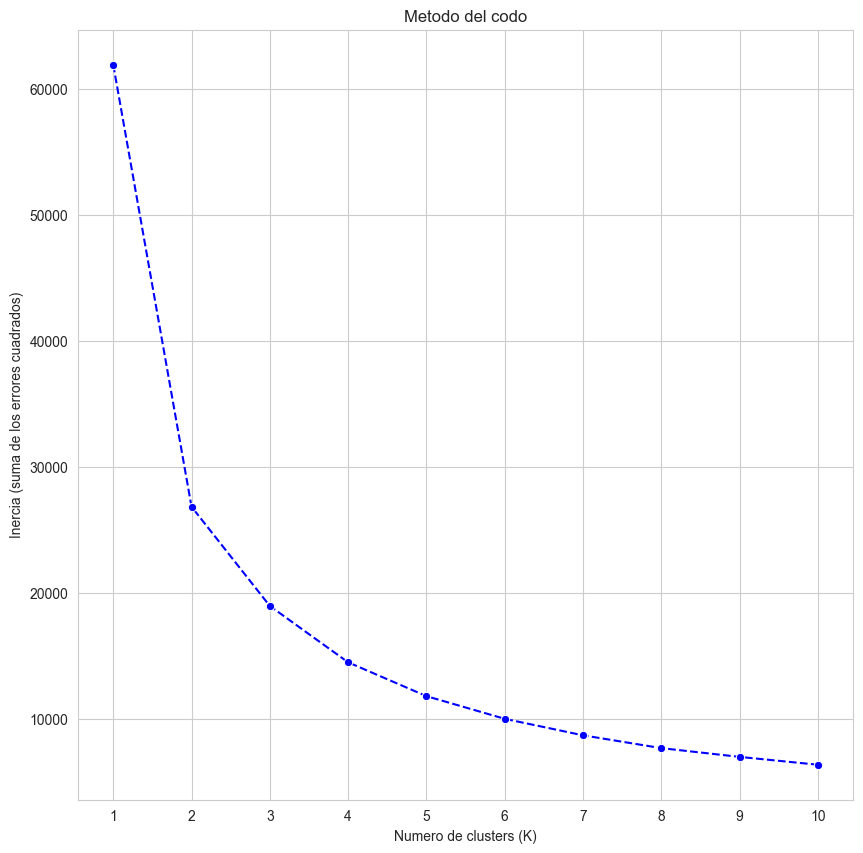

In [117]:
# Importo la libreria para poder ejecutar el modelo
# Importare matplotlib y seabron para graficar y ver donde la curva deja de caer bruscamente (el codo), ahi encontraré mi k optima
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Creo una lista donde se almacenaran las k
k_list = []
k_range = range(1,11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(data_scaled)
    k_list.append(km.inertia_)

# Grafico el codo
sns.set_style('whitegrid') # Mi tema favorito para graficos

plt.figure(figsize=(10,10))
sns.lineplot(x=k_range, y=k_list, marker='o', linestyle='--', color='b')
plt.title('Metodo del codo')
plt.xlabel('Numero de clusters (K)')
plt.ylabel('Inercia (suma de los errores cuadrados)')
plt.xticks(k_range) # Para asegurarnos que aparezcan todos los k
plt.show()


Visualmente podemos observar que en el cluster 3 (K = 3) la curva no decae radicalemente, por lo que se puede tomar como buena referencia para elegir el numero de clusters

# Entreno modelo KMeans
- El mejor cluster es 3 (K = 3)

In [118]:

k_best = 3

model_kn = KMeans(n_clusters=k_best, random_state=42, n_init=10)
model_kn.fit(data_scaled)

,n_clusters,4
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [119]:
# Preparo las etiquetas para poder realizar el grafico
labels = model_kn.labels_
# Agrego las etiquetas a mi data
data_copy['cluster'] = labels


### Grafico: Mapa de clusters.
-

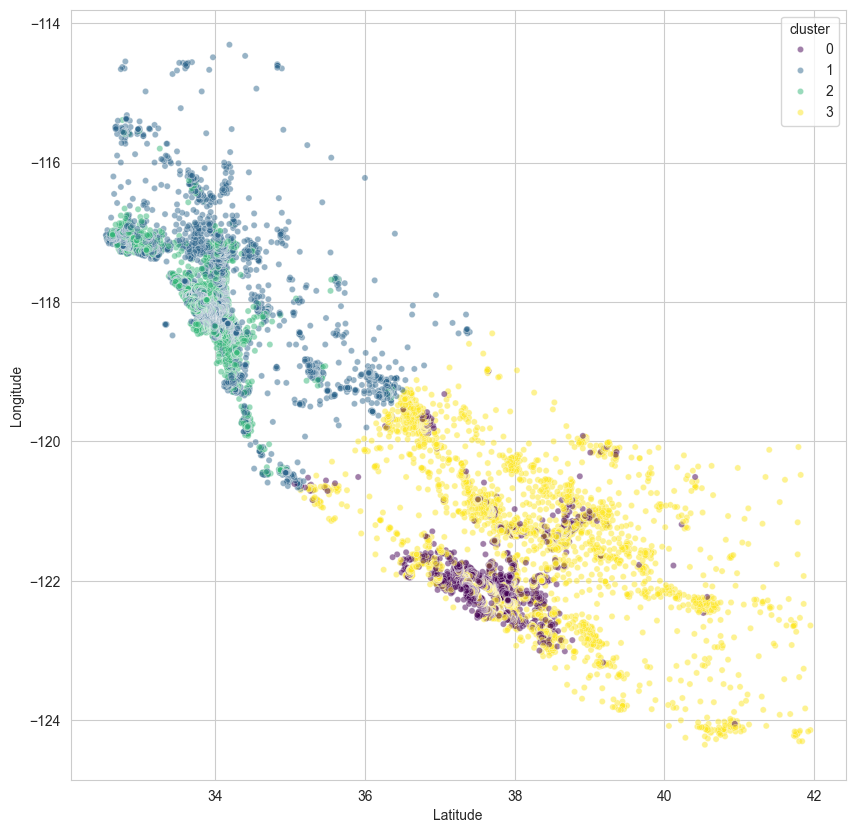

In [120]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=data_copy,
                x='Latitude',
                y='Longitude',
                hue='cluster',
                palette='viridis',
                alpha=0.5,
                s=20
               )
plt.show()
